### All References -

1. one-hot-encoding explanation: https://www.machinecurve.com/index.php/2020/11/24/one-hot-encoding-for-machine-learning-with-tensorflow-and-keras/

### Import the required libraries -

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')
import os


print("Imported libraries!")

Imported libraries!


### Check the dataset -

In [92]:
# Make sure the dataset exists.
from google.colab import files


trainCSVExists = os.path.exists('/content/drive/MyDrive/SureStartTrainingData/train.csv')
if trainCSVExists:
  print(f"train.csv dataset Exists: {trainCSVExists}")
else:
  print(f"train.csv dataset does not exist! Try importing it:")
  files.upload()

testCSVExists = os.path.exists('/content/drive/MyDrive/SureStartTrainingData/test.csv')
if testCSVExists:
  print(f"test.csv dataset Exists: {testCSVExists}")
else:
  print(f"test.csv dataset does not exist! Try importing it:")
  files.upload()

sampleSubmissionCSVExists = os.path.exists('/content/drive/MyDrive/SureStartTrainingData/sample_submission.csv')
if sampleSubmissionCSVExists:
  print(f"sample_submission.csv dataset Exists: {sampleSubmissionCSVExists}")
else:
  print(f"sample_submission.csv dataset does not exist! Try importing it:")
  files.upload()

# Check for GPU
import tensorflow as tf
deviceName = tf.test.gpu_device_name()
if deviceName != "/device:GPU:0":
  print(f"GPU not found!")
else:
  print(f"Found GPU: {deviceName}")

train.csv dataset Exists: True
test.csv dataset Exists: True
sample_submission.csv dataset Exists: True
Found GPU: /device:GPU:0


### Load the dataset -

In [93]:
trainingData = pd.read_csv('/content/drive/MyDrive/SureStartTrainingData/train.csv')
print(trainingData.shape)
trainingData.head()

testingData = pd.read_csv('/content/drive/MyDrive/SureStartTrainingData/test.csv')
print(testingData.shape)
testingData.head()


(42000, 785)
(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Retrieve the dataset into data frames -

Occurrences of each label:


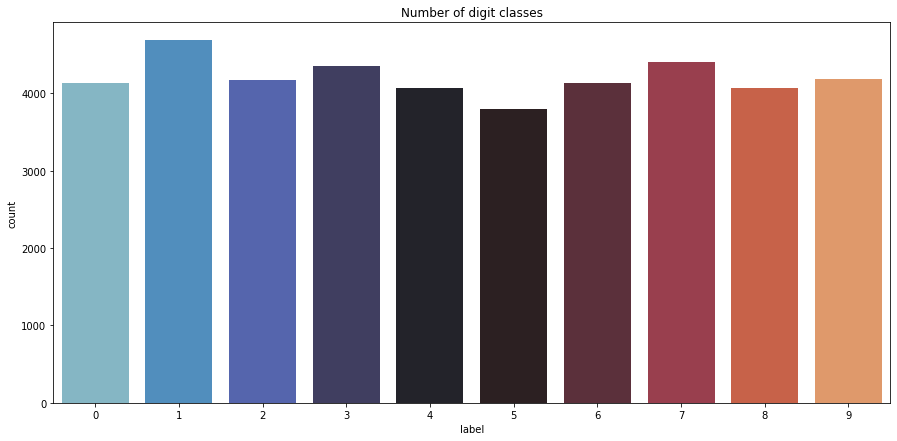

Sample from dataset:


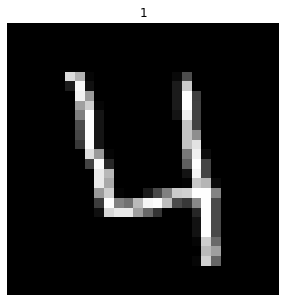

In [94]:
# Add the labels from the train.csv file into trainY
trainY = trainingData.label
# Drop the label column from the dataset
trainX = trainingData.drop(labels = ['label'], axis=1)

# Plot the occurrences of each label
print("Occurrences of each label:")
plt.figure(figsize=(15, 7))
g = sns.countplot(trainY, palette="icefire")
plt.title("Number of digit classes")
trainY.value_counts()
plt.show()

# Plot a sample of the dataset
print("Sample from dataset:")
plt.figure(figsize=(5,5))
img = trainX.iloc[3].to_numpy()
img = img.reshape((28, 28))
plt.imshow(img, cmap='gray')
plt.title(trainingData.iloc[0, 0])
plt.axis("off")
plt.show()

### Prepare the data -


1.   Normalization: Make all images grayscale to improve speed.
2.   Reshape: Reshape all images to 28x28x1 3D matrices.
3.   Encode Labels: Encode the labels to one-hot-encoded vectors
(one-hot-encoding reference: https://www.machinecurve.com/index.php/2020/11/24/one-hot-encoding-for-machine-learning-with-tensorflow-and-keras/)



In [95]:
# Normalization
print("Normalization:")
trainX = trainX / 255.0
print(f"# trainX normalized: {trainX.shape}")
testingData = testingData / 255.0
print(f"# testingData normalized: {testingData.shape}\n")

# Reshape
print("Reshape:")
trainXOld = trainX.copy()
trainX = trainX.values.reshape(-1, 28, 28, 1)
print(f"# trainX reshaped: {trainXOld.shape} => {trainX.shape}")
testingDataOld = testingData.copy()
testingData = testingData.values.reshape(-1, 28, 28, 1)
print(f"# testingData reshaped: {testingDataOld.shape} => {testingData.shape}\n")

# Encode Labels

# I am utiling the keras integration from tensorflow instead of the keras library as shown in the CNN tutorial from the curriculum
from tensorflow.keras.utils import to_categorical

print("Encode Labels:")
trainY = to_categorical(trainY, num_classes=10)
print(f"# trainY encoded: {trainY.shape}")

Normalization:
# trainX normalized: (42000, 784)
# testingData normalized: (28000, 784)

Reshape:
# trainX reshaped: (42000, 784) => (42000, 28, 28, 1)
# testingData reshaped: (28000, 784) => (28000, 28, 28, 1)

Encode Labels:
# trainY encoded: (42000, 10)


### Split the dataset into training and testing sets -

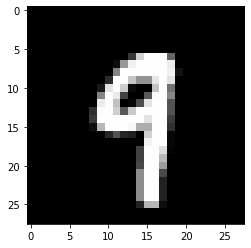

In [96]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1, random_state=2)

# Display example data as a plot
plt.imshow(trainX[2][:,:,0], cmap='gray')
plt.show()

### Create the CNN model -

In [97]:
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the model base
cnnModel = Sequential()
# Add the layers
cnnModel.add(Conv2D(filters = 8, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
cnnModel.add(MaxPool2D(pool_size=(2,2)))
cnnModel.add(Dropout(0.25))
cnnModel.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
cnnModel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
cnnModel.add(Dropout(0.25))

cnnModel.add(Flatten())
cnnModel.add(Dense(256, activation='relu'))
cnnModel.add(Dropout(0.5))
cnnModel.add(Dense(10, activation='softmax'))

# Set the optimizer
cnnOptimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
cnnModel.compile(optimizer=cnnOptimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)
datagen.fit(trainX)

# Fit the model
cnnHistory = cnnModel.fit_generator(datagen.flow(trainX, trainY, batch_size=250), epochs=10, validation_data=(valX, valY), steps_per_epoch=trainX.shape[0] // 250)


Epoch 1/10
151/151 [==============================] - 9s 58ms/step - loss: 1.5814 - accuracy: 0.4555 - val_loss: 0.2432 - val_accuracy: 0.9371
Epoch 2/10
151/151 [==============================] - 9s 58ms/step - loss: 0.4975 - accuracy: 0.8409 - val_loss: 0.1376 - val_accuracy: 0.9626
Epoch 3/10
151/151 [==============================] - 9s 57ms/step - loss: 0.3300 - accuracy: 0.8967 - val_loss: 0.1145 - val_accuracy: 0.9695
Epoch 4/10
151/151 [==============================] - 9s 57ms/step - loss: 0.2797 - accuracy: 0.9120 - val_loss: 0.0977 - val_accuracy: 0.9714
Epoch 5/10
151/151 [==============================] - 9s 57ms/step - loss: 0.2477 - accuracy: 0.9209 - val_loss: 0.0868 - val_accuracy: 0.9731
Epoch 6/10
151/151 [==============================] - 8s 56ms/step - loss: 0.2261 - accuracy: 0.9322 - val_loss: 0.0786 - val_accuracy: 0.9752
Epoch 7/10
151/151 [==============================] - 9s 56ms/step - loss: 0.2059 - accuracy: 0.9368 - val_loss: 0.0718 - val_accuracy: 0.9802

### Visualize the model -

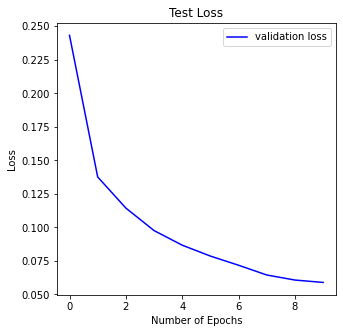

In [98]:
plt.figure(figsize=(5,5))
plt.plot(cnnHistory.history['val_loss'], color='b', label='validation loss')
plt.title('Test Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualize the Confusion Matrix -

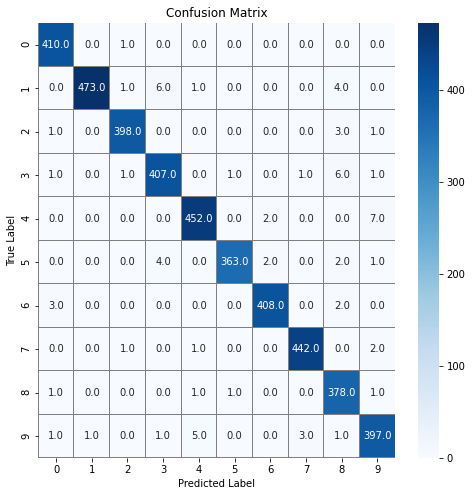

In [99]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
predictY = cnnModel.predict(valX)
# Convert predictions classes to one hot vectors 
predictYClasses = np.argmax(predictY,axis = 1) 
# Convert validation observations to one hot vectors
trueY = np.argmax(valY,axis = 1) 
# compute the confusion matrix
confusionMatrix = confusion_matrix(trueY, predictYClasses) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()